In [1]:
import pandas as pd
import os

# DATASET FROM: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# GF TODO: check if excel present, otherwise download it
# wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

excel_with_path  = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.xlsx'
pickle_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.pkl'
csv_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.csv'

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)

-> picke already exists, much faster using it than opening excel files



In [2]:
# define transaction: total cash for a single 'row' of the dataset, i.e. item_price times the number of items bought
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# day, week and time are added for convenience of analysis later on
from datetime import datetime
df['InvoiceDay'] = df['InvoiceDate'].map(lambda p: p.date())
df['InvoiceTime'] = df['InvoiceDate'].map(lambda p: p.time())
df['InvoiceWeek'] = df['InvoiceDate'].map(lambda p: p.isocalendar()[1]+52*(p.year-2010))

# avoide negative weeks and start counting from the first week of the dataset, which starts from 01/12/2009
df['InvoiceWeek'] = df['InvoiceWeek']+3


# implement the definition of cancellation in the documentation:
# http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#      ==> "If this code starts with the letter 'c', it indicates a cancellation.""
def is_cancellation(s):
    if isinstance(s, int):
        #print "ordinary invoice"
        return 0
    elif isinstance(s, unicode):
        #print "unicode string"
        if s.rfind('C')!=-1:
            return 1
        else:
            # print "Something unexpected"  # found, e.g. A506401
            # print s
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)     
      


# items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
# There'a lot of transactions with price set to 0, which based on the descriptions are 
max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item)        

# df.to_csv(csv_with_path, encoding = 'utf-8')

In [3]:
df.dtypes

Invoice                   object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
Price                    float64
Customer_ID              float64
Country                   object
Transaction              float64
InvoiceDay                object
InvoiceTime               object
InvoiceWeek                int64
IsCancellation             int64
IsOrdinaryItem             int64
dtype: object

In [4]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,07:45:00,0,0,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00,0,0,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00,0,0,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,07:45:00,0,0,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,07:45:00,0,0,1


In [5]:
# what are the nulls in each feature?
nulls = df.isnull().sum()[df.isnull().sum() != 0]

# select all transactions containing 
df_nulls = df[df.isnull().any(axis=1)].copy(deep=True)

nulls_rel = nulls/df.shape[0]*100

nulls_summary = pd.concat([nulls, nulls_rel], axis=1, keys=['nulls', 'rel. nulls [%]'])\
               .sort_values('nulls', ascending=False)

nulls_summary

,nulls,rel. nulls [%]
Customer_ID,243007,22.766873
Description,4382,0.410541


In [6]:
# df_nulls

In [7]:
# NEARLY all cancellations have either Quantity or Price set to negative values
# there are only two exceptions, here below:
#           one of which is an actual cancellation
#           the second of which is an onforeseen transaction type which starts with A
(df.loc[ (df.IsCancellation > 0.) & (df.Transaction > 0.) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,373.57,2010-02-01,08:24:00,8,1,1
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,14:50:00,87,2,0


In [8]:
# there are 6 data entries which are neither normal transactions nor cancellations which are neither 
# they're described as "Adjust bad debt"
(df.loc[ (df.IsCancellation == 2) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,-53594.36,2010-04-29,13:36:00,20,2,0
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,-44031.79,2010-07-19,11:24:00,32,2,0
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,-38925.87,2010-10-20,12:04:00,45,2,0
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,14:50:00,87,2,0
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,14:51:00,87,2,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,14:52:00,87,2,0


In [9]:
# remove the "Adjust bad debt"
df = (df.loc[ (df.IsCancellation < 2) ])

#from IPython.core.display import display, HTML
#display(HTML("""<a href="https://google.at">text</a>"""))

#<a id='the_destination'></a>

## todo
- nan and empty -> cleanup   # IN THE MAKING -> only consequences on the users study
- add colums for data and time, separately ?    # DONE
- create a second DF by user: RFM added to


## What do I want to extract from this dataset?
- https://en.wikipedia.org/wiki/Exploratory_data_analysis

- how many customers   DONE
- make a pliot of transaction, of purchase prices, and of invoice_price! #  DONE

- VS TIME: trends of spending overall, by country
- revenue as a function of date, as a function of the time in the day  # DONE
- trends of spending: overall, by the largest customer, by the smaller customers (TOO SPECIFIC?)

- NEED TO BUILD A PER CUSTOMER DF
- customer: how many transactions, how much total revenue:
    => BREAK DOWN BY country, tra
- RMF


- ==> do this
- how many different types of items
- what kind of items are bought the most (by NUMBER of by REVENUE), are cancelled the most, 
- how much revenue per type of item bought

- correlation between
- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?

- cust.groupby('customer_unique_id').size().value_counts() => The majority of customers made only a single purchase. # DONE


- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/
- now many items are bought per session, how much is spent per session

==> TOWARDS CUSTOMER PERSONA DEFINITION
- MANY TRANSACTIONS ARE RECORDED AT THE SAME TIME => as if they were a single shopping session, but billed in split goups of goods
- the function summary_data_from_transaction_data treats transactions taking place on the same day as A SINGLE ONE!

---
<a id="section_ID_GF"></a>

- this section can be reached at this URL https://swan001.cern.ch/user/franzoni/notebooks/SWAN_projects/proton/proton-EDA.ipynb#section_ID_GF
- thanks to this documentation

<a id="section_single_items"></a>
## SINGLE ITEM PRICE AND single item purchases
- how many single items are there (ordinary transaction) # DONE
- what is the cost of each single item
- what is the purchase frequency of each item

- what is the resulting price distribution for all transactions

In [10]:
# Exclude cancellations to get the spectrum of single items price
# motivation: the cancellation would give rise to a double counting

# NOTE: cancellations are sometimes negative Quantity for positive price,
# other times they are positive Quantity and negative price
tit='Unit Price'
#(df.loc[ (df.Price > 0.) & (df.Quantity > 0)]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))
(df.loc[ (df.IsCancellation ==0 ) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))

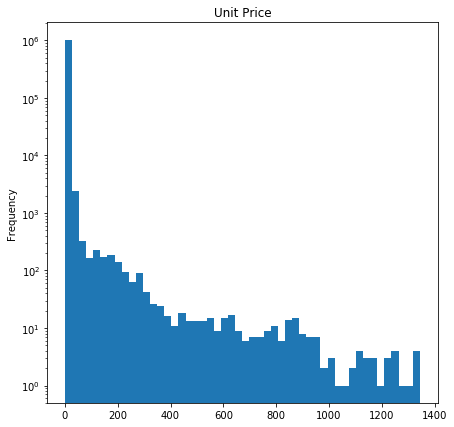

In [11]:
(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1)]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))

In [12]:
fraction_non_ordinary=100.*len(df.loc[  (df['IsOrdinaryItem']!=1)]) / len( (df.loc[  (df['IsOrdinaryItem']==1)])   )
print('%f percent of the total items are non ordinary, defined as above %d or zero'%(fraction_non_ordinary,max_item_price))

0.601802 percent of the total items are non ordinary, defined as above 1400 or zero


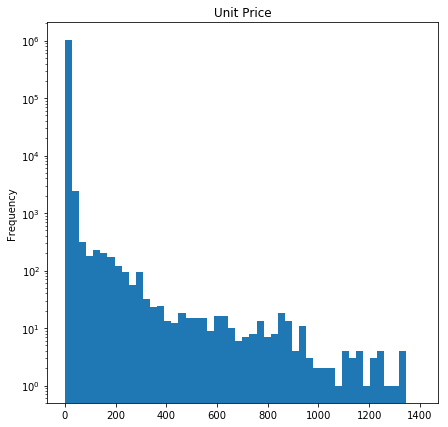

In [13]:
(df.loc[ (df.IsCancellation ==0 ) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

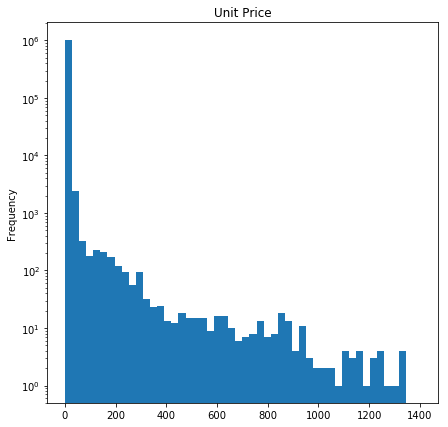

In [14]:
(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

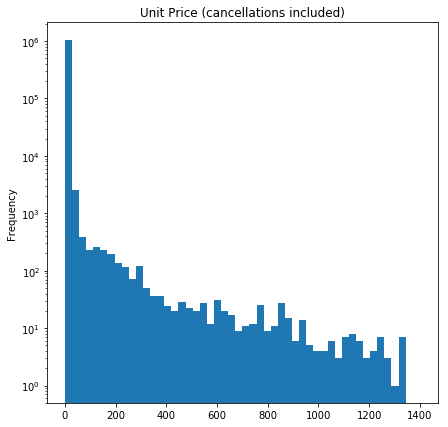

In [15]:
# alternative logic: account for cancelled items, as if they were normal purchases
tit='Unit Price (cancellations included)'
df['Price'].map(lambda p: abs(p)) \
           .plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

In [16]:
# What are the transactions-or-cancellations above max_item_price
# see them all
# df.loc[ (df.Price > max_item_price) | (df.Price < -1*max_item_price) ].head(20000)

# group them by Description to see what they are and how many 
df.loc[ (df.IsOrdinaryItem==0) & (df.Price>0) ].groupby('Description').Description.agg([len]) \
              .rename(columns={"len": "item_huge_price"})            \
              .sort_values(by=['item_huge_price'],ascending=False)


# All prices/cancellatons in excess of 1500 are 'special accounting actions',
# and are not actual goods being purchased

,item_huge_price
Description,
Manual,123
AMAZON FEE,39
DOTCOM POSTAGE,16
POSTAGE,2
Adjustment by john on 26/01/2010 17,1
Bank Charges,1
Discount,1


In [17]:
# how many ORDINARY items are on the cathalogue, based on unique description and price not set to 0
len(df.loc[ df.IsOrdinaryItem==1 ].Description.unique())

5414

In [18]:
# transactions with 0 prices --> all have odd/dodgy descriptions: manipulation errors and the like
df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)]
len(df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)])
# this is 0 by construction, since IsOrdinaryItem flips to 0 of Price==0

0

In [73]:
print('Several ordinary items are sold at different prieces; what fraction have different prices and what fraction has identical price?')

def is_price_unique(row):
    if row.min>=row.max and row.min<=row.max:
        row.price_unique=100 
        print('')

        print(row.min)
        print(row.max)
        print(row)
        print('--> the same')
    else:
        row.price_unique=999
        print('')
        print('')
        print(row.min)
        print(row.max)
        print(row)
        print('--> NOT the same')
    return row
# https://stackoverflow.com/questions/27474921/compare-two-columns-using-pandas

#a = df.loc[ df.IsOrdinaryItem==1 ].groupby('Description').Price.agg([len,min,max,sum]) \
#                                  .sort_values(by=['sum'],ascending=False)             \

#b=a.apply(is_price_unique, axis='columns')
#b

# IN THE MAKING
# TO DO: make a spectrum of the price for each element in the cathalogue

# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
import numpy as np
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
    
df_items = df.loc[ df.IsOrdinaryItem==1 ].groupby('Description')        \
                         .Price.agg([len,min,           \
                                    percentile(10),    \
                                    percentile(25),    \
                                    percentile(50),    \
                                    percentile(75),    \
                                    percentile(90),    \
                                    max,sum])          \
                                    .rename(columns={"sum": "item_revenue","len":"item_num"})  

# this is an indication of the spread of the price of a given item
df_items['percentile_7525'] = df_items['percentile_75'] / df_items['percentile_25'] 
df_items['percentile_9010'] = df_items['percentile_90'] / df_items['percentile_10'] 

df_items.loc[ df_items['item_revenue']>10000  ].sort_values(by=['item_revenue'],ascending=False)

Several ordinary items are sold at different prieces; what fraction have different prices and what fraction has identical price?


,item_num,min,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,max,item_revenue,percentile_7525,percentile_9010
Description,,,,,,,,,,,
DOTCOM POSTAGE,1423.0,0.350,30.00,68.6600,153.62,231.815,470.216,1325.00,291471.720,3.376274,15.673867
Manual,1296.0,0.030,0.42,1.2500,7.95,229.460,626.350,1343.44,217790.680,183.568000,1491.309524
REGENCY CAKESTAND 3 TIER,4408.0,4.000,10.95,12.7500,12.75,12.750,24.960,32.04,61747.010,1.000000,2.279452
POSTAGE,2113.0,0.500,15.00,18.0000,18.00,18.000,40.000,850.00,52941.190,1.000000,2.666667
WHITE HANGING HEART T-LIGHT HOLDER,5913.0,1.900,2.55,2.9500,2.95,2.950,2.950,6.77,18488.350,1.000000,1.156863
RED RETROSPOT CAKE STAND,1339.0,4.000,10.95,10.9500,10.95,10.950,20.790,21.23,16185.850,1.000000,1.898630
SET/4 WHITE RETRO STORAGE CUBES,349.0,34.950,34.95,39.9500,39.95,39.950,76.550,78.22,15856.610,1.000000,2.190272
PARTY BUNTING,2763.0,2.300,4.65,4.6500,4.95,4.950,9.130,15.79,15790.750,1.064516,1.963441
Bank Charges,95.0,0.001,15.00,15.0000,39.24,329.715,469.746,1050.15,15581.861,21.981000,31.316400


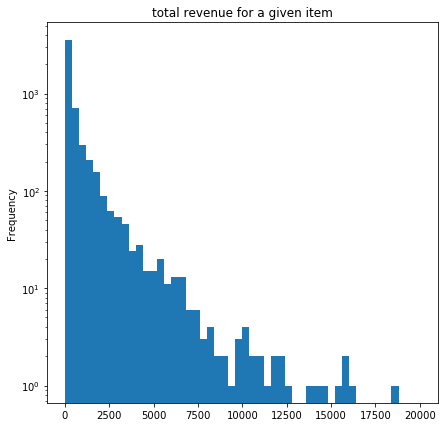

In [74]:
# how much money has been made with each given item
# excluding the top three values which are not purchasable items
tit='total revenue for a given item'
r  = (0,20000)
df_items['item_revenue'].plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

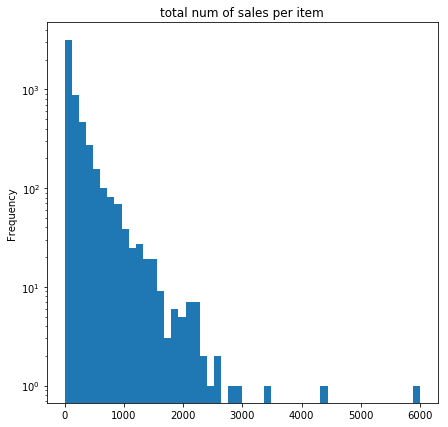

In [75]:
# how many times has each item been sold ?
tit='total num of sales per item'
r  = (0,6000)
df_items['item_num'].plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

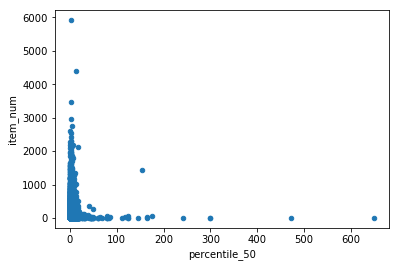

In [76]:
# correlation between number of times an item has been sold and its single price ?
df_items.plot.scatter(x='percentile_50',
                      y='item_num',
                      #c='species',
                      #colormap='viridis'
                     )

In [77]:
df_items['percentile_50'].values

array([ 6.75,  1.95,  2.55, ...,  0.85, 10.4 ,  3.75])

(array([[4.953e+03, 3.210e+02, 8.100e+01, 2.800e+01, 4.000e+00, 2.000e+00,
         0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00],
        [1.300e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

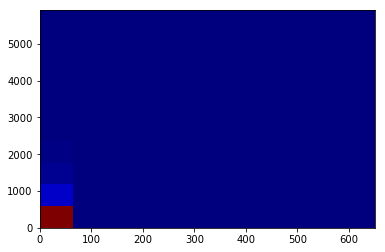

In [78]:
# this NOT a useful plot
import matplotlib.pyplot as plt
plt.hist2d(df_items['percentile_50'].values,df_items['item_num'].values,
              bins=(10,10),
             #cmap=plt.cm.coolwarm
              cmap=plt.cm.jet
          )

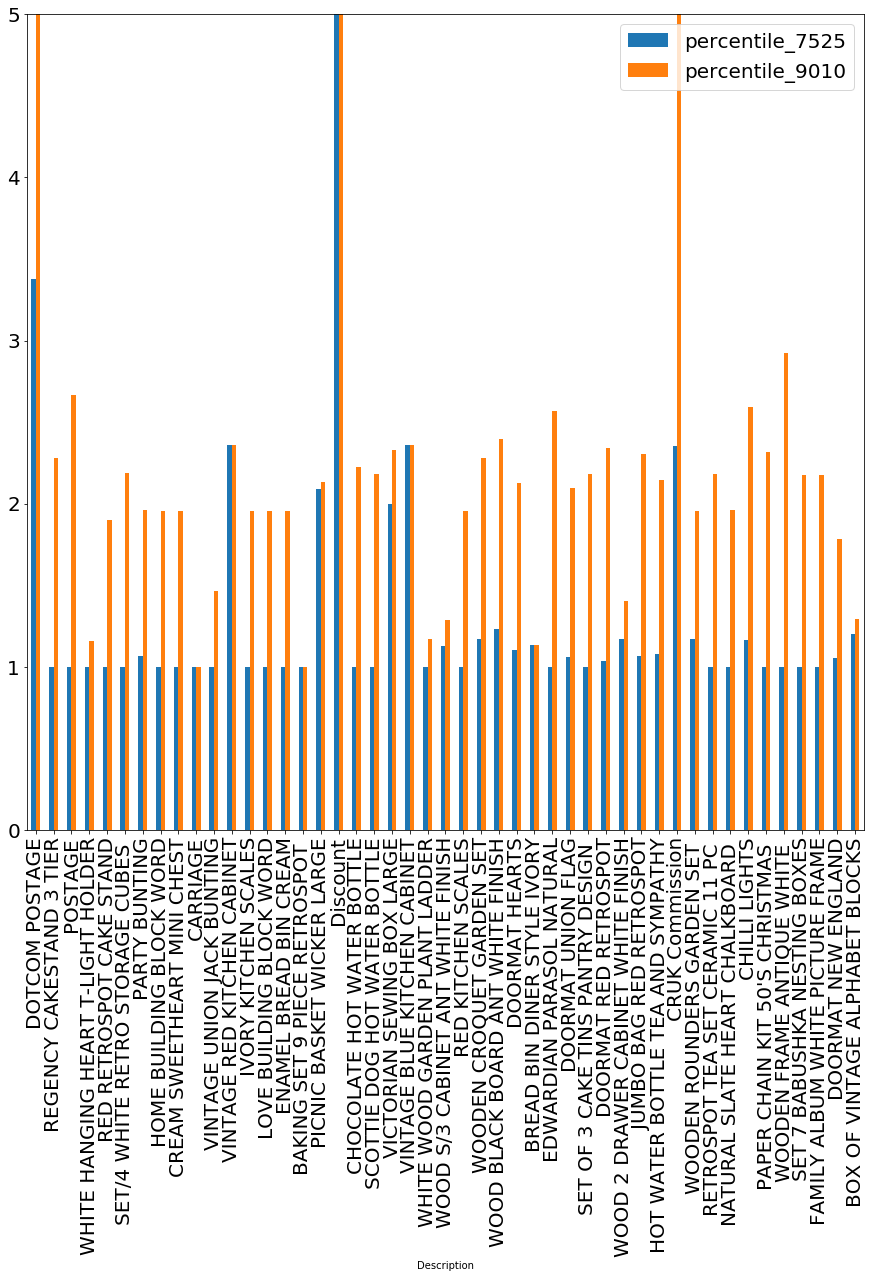

In [95]:
# relative difference between the 75 and the 25 percentile prices
# as function if item type, ordered by descending per-item total revenue
# the first three items are not actual purchable items
# 
df_items.loc[ (df_items['item_revenue']>7000) & (df_items['percentile_7525']<10) ]                        \
        .sort_values(by=['item_revenue'],ascending=False)[['percentile_7525','percentile_9010']]          \
        .plot.bar(rot=90,figsize=(15,15),logy=False,fontsize=20,ylim=(0,5),subplots=False)

plt.rc('legend',fontsize=20)

In [ ]:
<a id="section_single_items"></a>
## SINGLE ITEM PRICE AND single item purchases

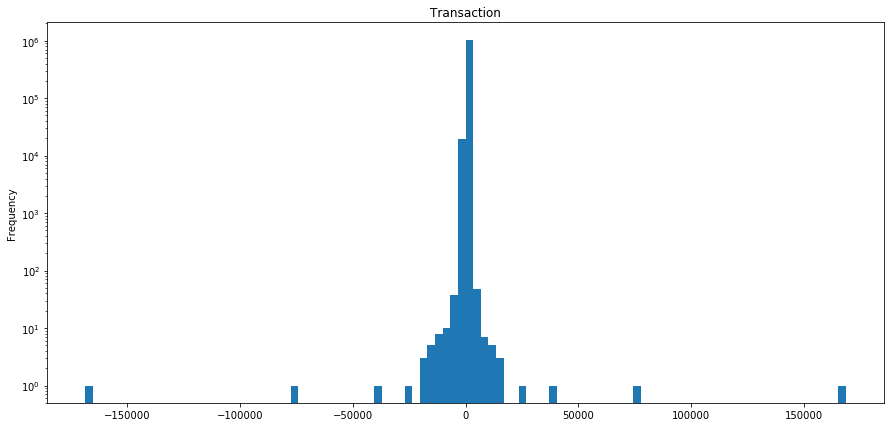

In [81]:
tit='Transaction'
df['Transaction'].plot(kind='hist',logy=True,title=tit,bins=100,figsize=(15,7))

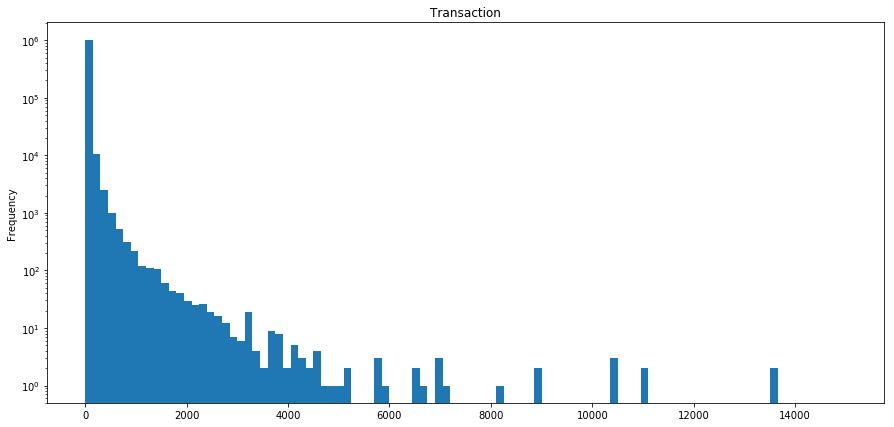

In [27]:
tit='Transaction'
df.loc[ (df.Transaction >0) ].Transaction.plot(kind='hist',logy=True,title=tit,bins=100,range=(0,15000),figsize=(15,7))

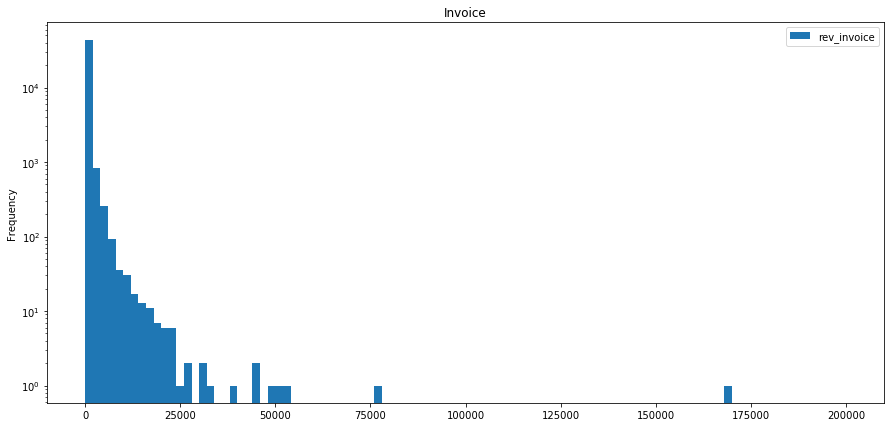

In [28]:
tit='Invoice'
df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \
   .sort_values(by=['rev_invoice'],ascending=False)  \
   .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,200000),figsize=(15,7))

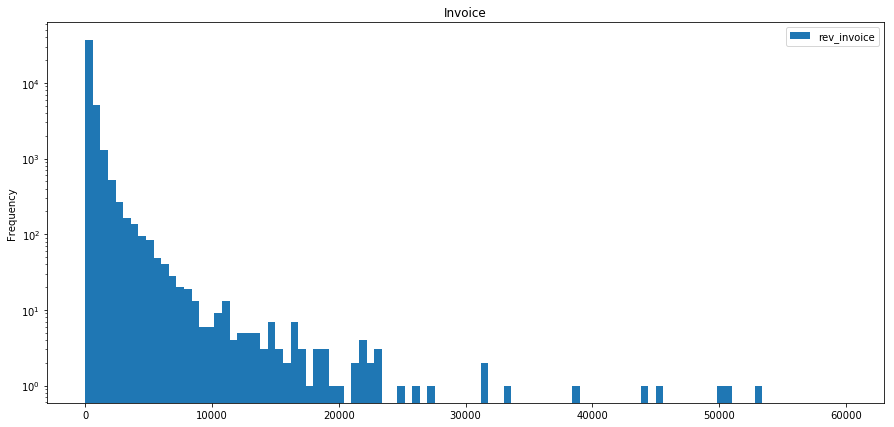

In [29]:
tit='Invoice'
df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \
   .sort_values(by=['rev_invoice'],ascending=False)  \
   .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,60000),figsize=(15,7))

In [30]:
print('There are %d unique customers'%len(df.Customer_ID.unique()))

There are 5943 unique customers


In [31]:
print('Customers are from %d countries'%len(df.Country.unique()))

Customers are from 43 countries


In [32]:
# I consider here only transactions with positive proceeds

transaction_plus   = (df.loc[df.Transaction > 0.]).Transaction.agg([sum])
transaction_cancel = (df.loc[df.Transaction < 0.]).Transaction.agg([sum])
print('The total cash intake is %e pounds,\n the total amount from cancellations is %e (%f )' \
        %(transaction_plus,transaction_cancel,-100*transaction_cancel/transaction_plus))

The total cash intake is 2.096191e+07 pounds,
 the total amount from cancellations is -1.527041e+06 (7.284841 )


In [33]:
# toggle between the whole dataset (df) and the transactions w/ Customer_ID=Nan 
# to check for biases
UU = df

Cust_vs_country = UU.groupby('Country').Customer_ID.unique().agg([len])     \
                    .rename(columns={"len": "num_customers"})               \
                    .sort_values(by=['num_customers'],ascending=False)

# I consider here only transactions with positive proceeds
# I'll make a dedicated plot/column here below for negative/cancelled goods
Revenue_vs_country = (UU.loc[UU.Transaction > 0.])                        \
                     .groupby('Country').Transaction.agg([sum])           \
                    .rename(columns={"sum": "revenue"})                     \
                    .sort_values(by=['revenue'],ascending=False)

Cancellation_vs_country = (UU.loc[UU.Transaction < 0.])                \
                          .groupby('Country').Transaction.agg([sum])    \
                          .rename(columns={"sum": "cancellation"})            \
                          .sort_values(by=['cancellation'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Items_vs_country = UU.groupby('Country').Invoice.agg([len])    \
                    .rename(columns={"len": "num_items"})            \
                    .sort_values(by=['num_items'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Invoices_vs_country = UU.groupby('Country').Invoice.unique().agg([len])    \
                    .rename(columns={"len": "num_invoices"})            \
                    .sort_values(by=['num_invoices'],ascending=False)

NoCustomerID_vs_country = df[df.isnull().any(axis=1)]                \
                    .groupby('Country').Transaction.agg([sum])     \
                    .rename(columns={"sum": "no_customer_id"})            \
                    .sort_values(by=['no_customer_id'],ascending=False) \

df_vs_country = Cust_vs_country              \
                .join(Revenue_vs_country )    \
                .join(Cancellation_vs_country)    \
                .join(Items_vs_country)   \
                .join(Invoices_vs_country)   \
                .join(NoCustomerID_vs_country,how='outer')   \
                .fillna(0)                                  \
                .sort_values(by=['revenue'],ascending=False) \

df_vs_country['rel_cancellation']   = \
           -100*df_vs_country['cancellation']/df_vs_country['revenue']

df_vs_country['rel_no_customer_id'] = \
            100*df_vs_country['no_customer_id']/df_vs_country['revenue']

In [34]:
NoCustomerID_vs_country

,no_customer_id
Country,
United Kingdom,2.723775e+06
EIRE,3.701792e+04
Hong Kong,1.403930e+04
Unspecified,2.310560e+03
France,1.687130e+03
Bahrain,1.507180e+03
RSA,1.435290e+03
Bermuda,1.253140e+03
Israel,9.135700e+02


In [35]:
df_vs_country

,num_customers,revenue,cancellation,num_items,num_invoices,no_customer_id,rel_cancellation,rel_no_customer_id
Country,,,,,,,,
United Kingdom,5411,1.786029e+07,-1330091.31,981324,49102,2.723775e+06,7.447199,15.250453
EIRE,6,6.644318e+05,-48912.23,17866,806,3.701792e+04,7.361513,5.571365
Netherlands,23,5.542323e+05,-5707.39,5140,250,0.000000e+00,1.029783,0.000000
Germany,107,4.312625e+05,-13273.90,17624,1095,0.000000e+00,3.077917,0.000000
France,96,3.569446e+05,-28752.80,14330,746,1.687130e+03,8.055256,0.472659
Australia,15,1.699681e+05,-2839.04,1913,117,0.000000e+00,1.670337,0.000000
Spain,41,1.091785e+05,-17319.05,3811,188,0.000000e+00,15.863055,0.000000
Switzerland,23,1.010113e+05,-1282.53,3189,123,6.459500e+02,1.269690,0.639483
Sweden,20,9.190372e+04,-4094.30,1364,129,3.540000e+02,4.454988,0.385186


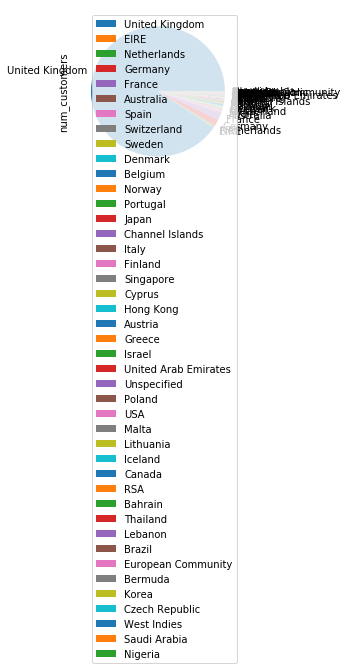

In [36]:
# https://www.w3resource.com/pandas/dataframe/dataframe-plot-bar.php
# good reference for plotting directly from pandas (less code!)
df_vs_country.plot.pie(y='num_customers', figsize=(3, 3))

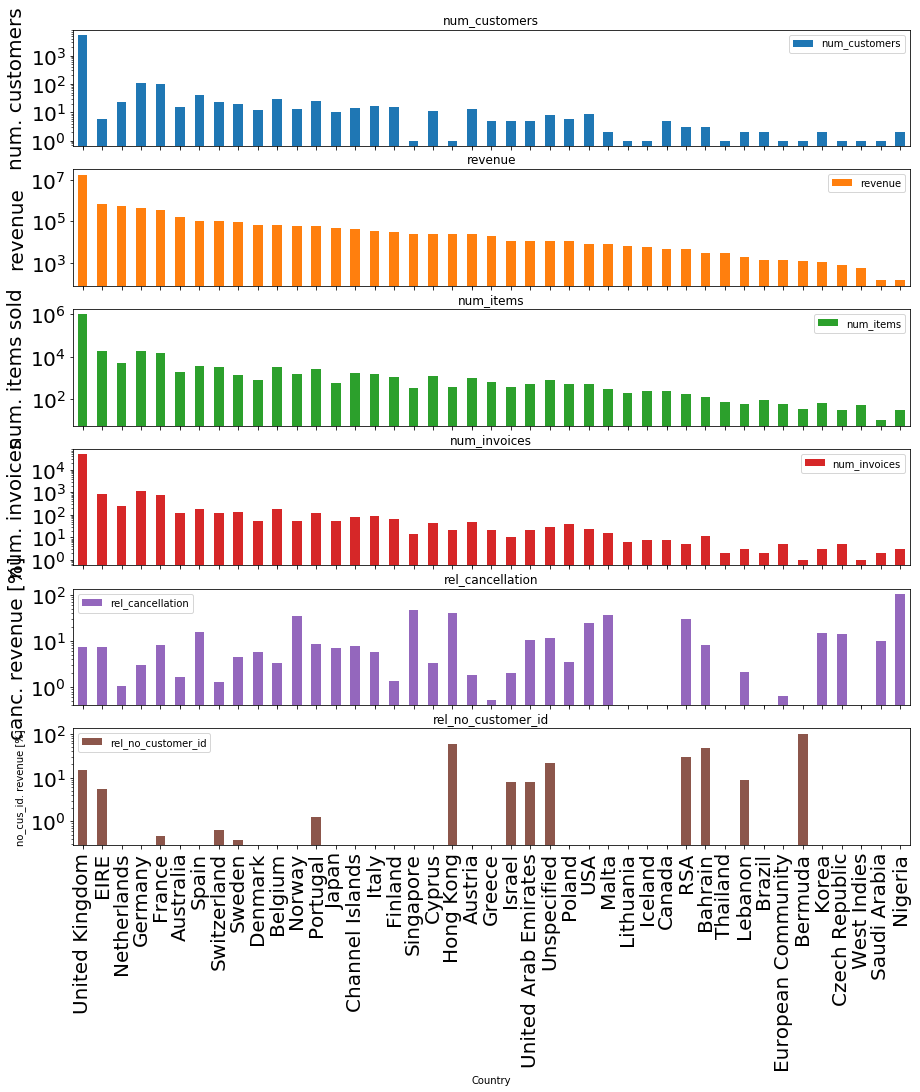

In [37]:
ax= df_vs_country.drop(['cancellation','no_customer_id'], axis=1)  \
    .plot.bar(rot=90,figsize=(15,15),logy=True,fontsize=20,subplots=True)

ax[0].set(ylabel = 'num. customers')
ax[1].set(ylabel = 'revenue')
ax[2].set(ylabel = 'num. items sold')
ax[3].set(ylabel = 'num. invoices')
ax[4].set(ylabel = 'canc. revenue [%]')
# ax[4].set_yscale('linear')
ax[5].set(ylabel = 'no_cus_id. revenue [%]')
#ax[5].set_yscale('linear')

for v in range(5):
    ax[v].yaxis.get_label().set_fontsize(20)

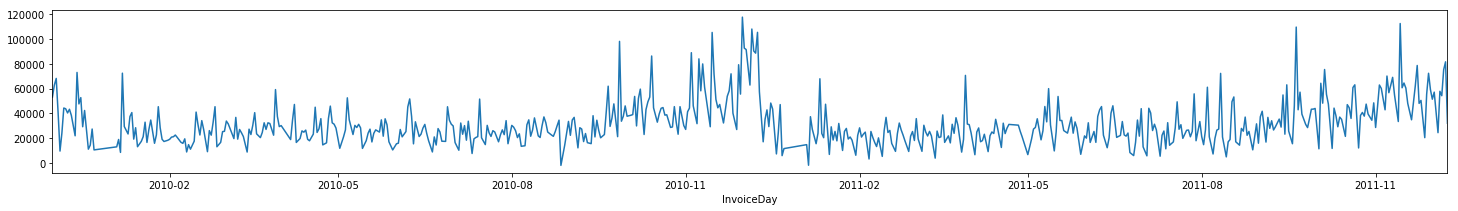

In [38]:
df.groupby('InvoiceDay').Transaction.agg(sum).plot(figsize=(25, 3))

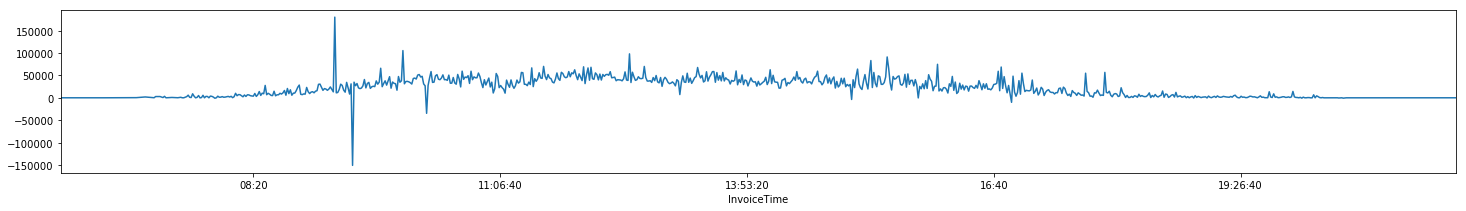

In [39]:
df.groupby('InvoiceTime').Transaction.agg(sum).plot(figsize=(25, 3))  # must be limited to >0

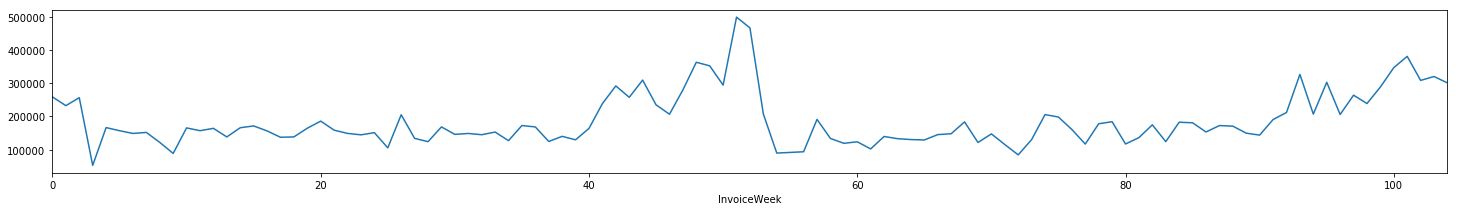

In [40]:
df.groupby('InvoiceWeek').Transaction.agg(sum).plot(figsize=(25, 3))

In [41]:
# the largest customer by total net revenue (i.e. taking into account also cancellations, in negative)
# is in the UK and has ID 18102.0 and has purchased for 600k pounds
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Total Customer Revenue'],ascending=False).head(10)        

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
18102.0,598215.22,-3580.80,3884.00,1068.0
14646.0,523342.07,-947.08,4992.00,3890.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14911.0,270248.53,-1687.17,1687.17,11613.0
17450.0,233579.39,-3825.36,7144.72,448.0
13694.0,190825.52,-864.00,952.00,1558.0
17511.0,171885.98,-185.30,1401.60,2134.0
12415.0,143269.29,-425.00,1718.40,990.0
16684.0,141502.25,-816.00,1836.00,749.0


In [42]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 13.1k transactions
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,69516.19,-88.50,349.50,13097.0
14911.0,270248.53,-1687.17,1687.17,11613.0
12748.0,49970.13,-1829.84,850.50,7307.0
14606.0,30094.38,-55.10,139.30,6709.0
14096.0,57120.91,-1100.44,1599.26,5128.0
15311.0,113513.07,-275.00,408.00,4717.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14646.0,523342.07,-947.08,4992.00,3890.0
13089.0,113214.19,-1051.20,1051.20,3438.0


In [43]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 12.9 transactions (excluding cancellation transactions)
df.loc[df.Transaction>0]                                                                                      \
    .groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,70884.07,0.19,349.50,12890.0
14911.0,295972.63,1.45,1687.17,11245.0
12748.0,56599.39,0.06,850.50,7228.0
14606.0,30861.06,0.12,139.30,6566.0
14096.0,65164.79,0.42,1599.26,5111.0
15311.0,116771.16,0.21,408.00,4434.0
14156.0,313946.37,1.25,2736.16,4048.0
14646.0,528602.52,0.39,4992.00,3849.0
13089.0,116737.86,1.68,1051.20,3362.0


In [44]:
# the UK generates the largest revenue (16M over the two years),
# surprisingly EIRE is the second largest source of revenue, with 0.6M (despite having only 6 customers, they must be huge customers)
df.groupby('Country').Transaction.sum().sort_values(ascending=False)

Country
United Kingdom          1.653020e+07
EIRE                    6.155196e+05
Netherlands             5.485250e+05
Germany                 4.179886e+05
France                  3.281918e+05
Australia               1.671291e+05
Switzerland             9.972876e+04
Spain                   9.185948e+04
Sweden                  8.780942e+04
Denmark                 6.574109e+04
Belgium                 6.357449e+04
Portugal                5.313680e+04
Japan                   4.377658e+04
Channel Islands         4.145361e+04
Norway                  3.924303e+04
Italy                   3.067935e+04
Finland                 2.951445e+04
Cyprus                  2.416274e+04
Austria                 2.317760e+04
Greece                  1.899549e+04
Hong Kong               1.403930e+04
Singapore               1.315816e+04
Israel                  1.110722e+04
Poland                  1.052809e+04
United Arab Emirates    9.948650e+03
Unspecified             9.687320e+03
Lithuania               6.5537

In [45]:
df.groupby('Country').Transaction.sum().sort_values(ascending=False)

Country
United Kingdom          1.653020e+07
EIRE                    6.155196e+05
Netherlands             5.485250e+05
Germany                 4.179886e+05
France                  3.281918e+05
Australia               1.671291e+05
Switzerland             9.972876e+04
Spain                   9.185948e+04
Sweden                  8.780942e+04
Denmark                 6.574109e+04
Belgium                 6.357449e+04
Portugal                5.313680e+04
Japan                   4.377658e+04
Channel Islands         4.145361e+04
Norway                  3.924303e+04
Italy                   3.067935e+04
Finland                 2.951445e+04
Cyprus                  2.416274e+04
Austria                 2.317760e+04
Greece                  1.899549e+04
Hong Kong               1.403930e+04
Singapore               1.315816e+04
Israel                  1.110722e+04
Poland                  1.052809e+04
United Arab Emirates    9.948650e+03
Unspecified             9.687320e+03
Lithuania               6.5537

In [46]:
df.groupby('Customer_ID').size().value_counts()

1       146
6        84
11       82
16       80
12       79
18       77
13       76
5        75
20       74
21       74
7        73
8        72
9        71
14       70
19       67
2        65
10       64
23       64
17       60
4        60
35       58
15       58
29       57
28       56
22       55
25       54
26       54
27       53
30       53
34       52
       ... 
658       1
662       1
694       1
718       1
730       1
750       1
478       1
462       1
1049      1
446       1
1069      1
1089      1
1109      1
1133      1
1241      1
1301      1
1353      1
1419      1
178       1
234       1
282       1
330       1
362       1
390       1
394       1
402       1
406       1
422       1
434       1
1885      1
Length: 701, dtype: int64

<a id='the_destination'></a>

[Pippo goes to the cinema](section-title)